Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reloading Tuner from my_dir/hparam_tuning/tuner0.json
Epoch 1/50
43/43 [==============================] - 1s 9ms/step - loss: 2.2519 - accuracy: 0.5407 - val_loss: 0.6190 - val_accuracy: 0.8333
Epoch 2/50
43/43 [==============================] - 0s 5ms/step - loss: 0.3110 - accuracy: 0.9193 - val_loss: 0.3588 - val_accuracy: 0.9133
Epoch 3/50
43/43 [==============================] - 0s 5ms/step - loss: 0.1574 - accuracy: 0.9630 - val_loss: 0.2746 - val_accuracy: 0.9200
Epoch 4/50
43/43 [==============================] - 0s 5ms/step - loss: 0.0892 - accuracy: 0.9793 - val_loss: 0.3418 - val_accuracy: 0.9267
Epoch 5/50
43/43 [==============================] - 0s 6ms/step - loss: 0.0565 - accuracy: 0.9867 - val_loss: 0.2674 - val_accuracy: 0.9433
Epoch 6/50
43/43 [==============================] - 0s 5ms/step - loss: 0.0546 - accuracy: 0.9859 - val_loss: 0.2315 

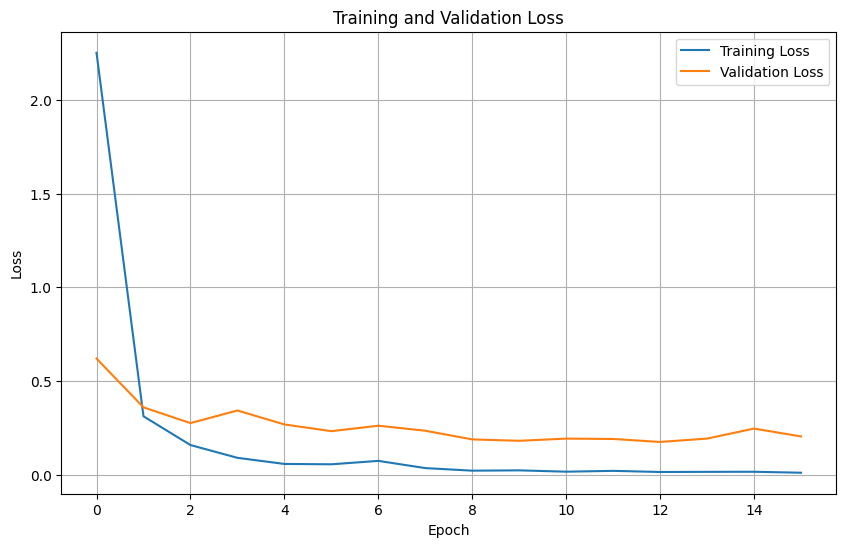

10/10 [==============================] - 0s 3ms/step - loss: 0.1738 - accuracy: 0.9500
Test Loss: 0.17381267249584198
Test Accuracy: 0.949999988079071
10/10 [==============================] - 0s 3ms/step


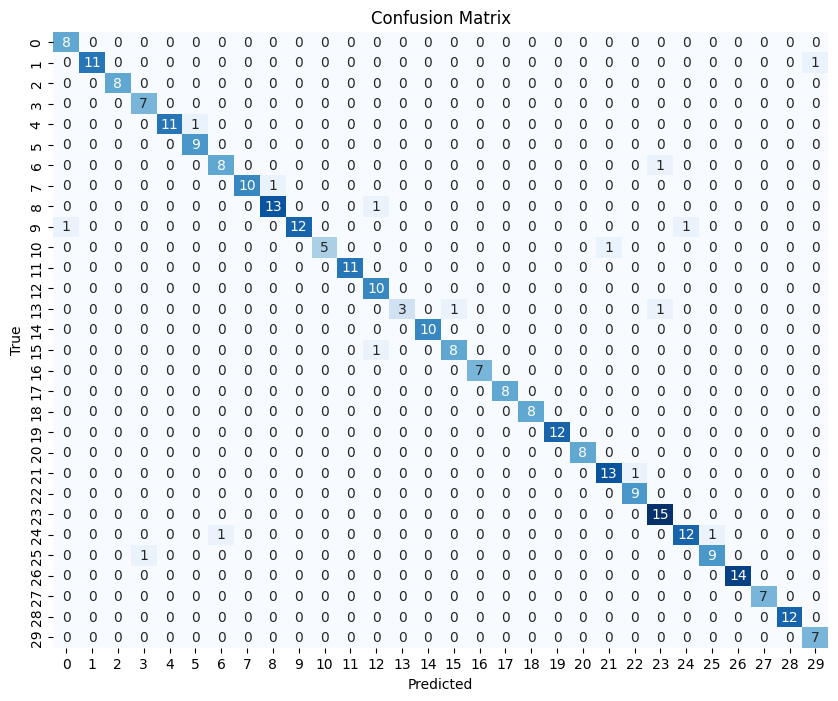

Classification Report:
              precision    recall  f1-score   support

           2       0.89      1.00      0.94         8
           3       1.00      0.92      0.96        12
           4       1.00      1.00      1.00         8
           5       0.88      1.00      0.93         7
           6       1.00      0.92      0.96        12
           7       0.90      1.00      0.95         9
           8       0.89      0.89      0.89         9
           9       1.00      0.91      0.95        11
          11       0.93      0.93      0.93        14
          12       1.00      0.86      0.92        14
          13       1.00      0.83      0.91         6
          15       1.00      1.00      1.00        11
          16       0.83      1.00      0.91        10
          17       1.00      0.60      0.75         5
          18       1.00      1.00      1.00        10
          20       0.89      0.89      0.89         9
          22       1.00      1.00      1.00         7
    

In [3]:
from google.colab import drive
drive.mount('/content/drive')

!pip install keras-tuner --upgrade

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from keras_tuner.tuners import RandomSearch
import seaborn as sns
import matplotlib.pyplot as plt

class CascadeCorrelationNN:
    def __init__(self, input_shape, num_classes):
        self.model = None
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.layers_config = [num_classes]  # Start with only the output layer
        self.build_model()

    def build_model(self):
        inputs = Input(shape=(self.input_shape,))
        x = inputs
        for idx, units in enumerate(self.layers_config):
            activation = 'softmax' if idx == len(self.layers_config) - 1 else 'relu'
            x = Dense(units, activation=activation)(x)
        self.model = Model(inputs=inputs, outputs=x)
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    def add_layer(self, units=1):
        self.layers_config.insert(-1, units)  # Insert before the last layer (output layer)
        self.build_model()

    def train(self, X_train, y_train, X_val, y_val, epochs=1):
        return self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs)

    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)

def load_and_preprocess_data():
    y_filename = '/content/drive/My Drive/yaleExtB_target.npy'
    X_filename = '/content/drive/My Drive/yaleExtB_data.npy'
    y = np.load(y_filename)
    X = np.load(X_filename)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    oversampler = RandomOverSampler()
    X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train_scaled, y_train)

    y_train_balanced_one_hot = to_categorical(y_train_balanced, num_classes=40)
    y_test_one_hot = to_categorical(y_test, num_classes=40)

    pca = PCA(n_components=100)
    X_train_pca = pca.fit_transform(X_train_balanced)
    X_test_pca = pca.transform(X_test_scaled)

    return X_train_pca, X_test_pca, y_train_balanced_one_hot, y_test_one_hot

# Define the hypermodel function for Keras Tuner
def build_hypermodel(hp):
    num_layers = hp.Int('num_layers', 1, 5)
    units_per_layer = [hp.Int('units_' + str(i), min_value=32, max_value=512, step=32) for i in range(num_layers)]

    inputs = Input(shape=(100,))  # Adjust based on your PCA components
    x = inputs
    for units in units_per_layer:
        x = Dense(units, activation='relu')(x)
    outputs = Dense(40, activation='softmax')(x)  # num_classes is 40

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Load and preprocess data
X_train, X_test, y_train, y_test = load_and_preprocess_data()

# EarlyStopping callback setup
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Perform hyperparameter tuning using Keras Tuner
tuner = RandomSearch(
    build_hypermodel,
    objective='val_accuracy',
    max_trials=10,  # Adjusted for brevity in example
    executions_per_trial=1,
    directory='my_dir',
    project_name='hparam_tuning'
)

tuner.search(
    X_train, y_train,
    epochs=10,  # Adjusted for brevity in example
    validation_data=(X_test, y_test),
    callbacks=[early_stopper]  # Add the EarlyStopping callback here
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model = build_hypermodel(best_hps)

# Train the model and capture training history
history = model.fit(
    X_train, y_train,
    epochs=50,  # This may be adjusted based on early stopping
    validation_data=(X_test, y_test),
    callbacks=[early_stopper]  # Add the EarlyStopping callback during final training
)

# Plot training loss vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true classes
y_true_classes = np.argmax(y_test, axis=1)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true_classes, y_pred_classes), annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_hps.values)
